## Packages and Data

Read in and clean the 'Housing Price Gap' Data

In [300]:
import pandas as pd # Needed for reading csv
import numpy as np # Needed for setting : to nan
import matplotlib.pyplot as plt # For graphing
import seaborn as sns # For fancy plots

In [301]:
raw_ratio = pd.read_csv('Data/House_Price_Wages_Ratio.csv', # Read in the csv for the ratio data
                        encoding = 'utf-8')
raw_ratio.columns

Index(['New Code', 'Old Code', 'Area', '2002', '2003', '2004', '2005', '2006',
       '2007', '2008', '2009', '2010', '2011', '2012', '2013', '2014', '2015',
       '2016', '2017', '2018', '2019', '2020'],
      dtype='object')

In [302]:
# Desired columns only
# Keep the "Old Code" becuase the tourism spend data doesn't have the new code
# This will allow a separate join on this column to work for this dataset
ratio = raw_ratio[['New Code','Old Code','Area','2019']].dropna().rename(columns={
    'New Code': 'Area_Code',
    'Old Code': 'Old_Code',
    '2019': 'House_Earnings_Ratio'})
ratio.head()

,Area_Code,Old_Code,Area,House_Earnings_Ratio
1,E09000001,00AA,City of London,:
2,E09000002,00AB,Barking and Dagenham,10.75
3,E09000003,00AC,Barnet,14.19
4,E09000004,00AD,Bexley,9.61
5,E09000005,00AE,Brent,15.59


In [303]:
# Get rid of 'City of London' value, which has an NaN stored as ':'
ratio = ratio.drop(ratio[ratio.House_Earnings_Ratio == ':'].index)
# Get rid of 'London' from the bottom
ratio = ratio.drop(ratio[ratio.Area == 'London'].index)

ratio.head()

,Area_Code,Old_Code,Area,House_Earnings_Ratio
2,E09000002,00AB,Barking and Dagenham,10.75
3,E09000003,00AC,Barnet,14.19
4,E09000004,00AD,Bexley,9.61
5,E09000005,00AE,Brent,15.59
6,E09000006,00AF,Bromley,10.73


In [304]:
# Convert the column to floats, so that it can be plotted
ratio['House_Earnings_Ratio'] = pd.to_numeric(ratio['House_Earnings_Ratio'])
ratio.dtypes

Area_Code                object
Old_Code                 object
Area                     object
House_Earnings_Ratio    float64
dtype: object

In [305]:
raw_rental = pd.read_excel('Data/Rental_Rates.xls', # Read in the excel sheet
                           sheet_name = 'Table2.7')
# There's loads of junk at the top, with the column headings I want on row five
# I save the row I want as a variable to assign as the index labels later
header_row = raw_rental.iloc[5]

In [306]:
# Drop the first five rows, including the row we want as the index labels, so its not repeated
rental_cleaned = raw_rental.drop(list(range(6)))
rental_cleaned.columns = header_row # Assign the row from before as index labels
rental_cleaned.head()

5,NaN,LA Code1,Area Code1,Area,Count of rents,Mean,Lower quartile,Median,Upper quartile
6,NaN,NaN,E92000001,ENGLAND,480750,898,585,755,1050
7,NaN,NaN,E12000001,NORTH EAST,23690,572,425,500,625
8,NaN,1355,E06000047,County Durham UA,5650,516,400,475,550
9,NaN,1350,E06000005,Darlington UA,2300,501,400,450,550
10,NaN,724,E06000001,Hartlepool UA,800,494,415,495,550


In [307]:
# Pick out the desired columns and relabel them
# I must make sure all dataframes have the area codes stored under "Area_Code" for merging
rental_data = rental_cleaned[['Area Code1','Count of rents','Mean']].rename(columns={
    'Area Code1': 'Area_Code',
    'Count of rents':'Rent_Count',
    'Mean':'Rent_Price_Mean'})
rental_data.head()

# NOTE: This dataset includes all other administrative areas in the UK as well

5,Area_Code,Rent_Count,Rent_Price_Mean
6,E92000001,480750,898
7,E12000001,23690,572
8,E06000047,5650,516
9,E06000005,2300,501
10,E06000001,800,494


In [308]:
raw_open_space = pd.read_csv('Data/Open_Space.csv', # Read in the csv
                        encoding = 'utf-8')
raw_open_space.columns

Index(['Ward_GSS_CODE', 'Ward_NAME', 'BOROUGH_LB_GSS_CD', 'BOROUGH_Name',
       'Total area of ward (sq m)', 'All Open Space', '% open space',
       'Open Space with access', '% Open Space with access',
       '% of open space that has access'],
      dtype='object')

In [309]:
# Select desired columns and rename, keeping Area_Code consistent
open_space = raw_open_space[['Ward_GSS_CODE',
                             'Total area of ward (sq m)',
                             '% open space']].rename(columns={
    'Ward_GSS_CODE':'Area_Code',
    'Total area of ward (sq m)': 'Land_Area(m^2)',
    '% open space':'%Open_Space_2013'})
# I have to remove the commas in the land area data and convert it to a float
open_space['Land_Area(m^2)'] = open_space['Land_Area(m^2)'].str.replace(',','').astype('float')

In [310]:
open_space.head()

# NOTE: All the wards are in the dataframe as well, with the boroughs at the bottom
# The area code will serve as a unique identify for the boroughs and filter out the wards

,Area_Code,Land_Area(m^2),%Open_Space_2013
0,E05000026,1282926.0,21.9
1,E05000027,1364442.0,20.6
2,E05000028,1288085.0,1.9
3,E05000029,3384193.0,56.0
4,E05000030,3450576.0,50.4


In [311]:
raw_tourism_spend = pd.read_csv('Data/Tourism_Spend_2009.csv', # Read in the csv
                                encoding = 'utf-8')
raw_tourism_spend.columns

Index(['Code', 'Area', 'Overseas visitors (£ millions)',
       'Domestic visitors (£ millions)', 'Day visitors (£ millions)'],
      dtype='object')

In [312]:
# I need to sum the two values fir international and domestic spend together first
raw_tourism_spend.dtypes

Code                              object
Area                              object
Overseas visitors (£ millions)    object
Domestic visitors (£ millions)    object
Day visitors (£ millions)         object
dtype: object

In [313]:
tourism_spend_processed = raw_tourism_spend
tourism_spend_processed['Overseas visitors (£ millions)'] = tourism_spend_processed['Overseas visitors (£ millions)'].str.replace(',','').astype('float')
tourism_spend_processed['Domestic visitors (£ millions)'] = tourism_spend_processed['Domestic visitors (£ millions)'].str.replace(',','').astype('float')

In [314]:
tourism_spend_processed['Tourism_Spend_2009(£m)'] = sum((tourism_spend_processed['Overseas visitors (£ millions)'],
                                                    tourism_spend_processed['Domestic visitors (£ millions)']))
tourism_spend_processed.dtypes

Code                               object
Area                               object
Overseas visitors (£ millions)    float64
Domestic visitors (£ millions)    float64
Day visitors (£ millions)          object
Tourism_Spend_2009(£m)            float64
dtype: object

In [315]:
# Note, this has the old area codes
tourism_spend_2009 = raw_tourism_spend[['Code',
                             'Tourism_Spend_2009(£m)']].rename(columns={
    'Code':'Old_Code'})

## Data Joining

In [316]:
# Now I'm ready to start joining the data
y_with_tourism = ratio.merge(tourism_spend_2009, on='Old_Code', how='inner')
# Having joined on the old code, I can now get rid of it
y_with_tourism = y_with_tourism.drop('Old_Code', axis=1)
y_with_tourism.head()

,Area_Code,Area,House_Earnings_Ratio,Tourism_Spend_2009(£m)
0,E09000002,Barking and Dagenham,10.75,57.0
1,E09000003,Barnet,14.19,186.0
2,E09000004,Bexley,9.61,106.0
3,E09000005,Brent,15.59,151.0
4,E09000006,Bromley,10.73,151.0


In [317]:
# I can now merge the other two dataframes on the Area_Code column
full_data = y_with_tourism
# I can't do them both together with merge() so have to iterate
for df in [rental_data, open_space]: 
    full_data = full_data.merge(df,
                                on = 'Area_Code',
                                how = 'inner')

full_data.head()

,Area_Code,Area,House_Earnings_Ratio,Tourism_Spend_2009(£m),Rent_Count,Rent_Price_Mean,Land_Area(m^2),%Open_Space_2013
0,E09000002,Barking and Dagenham,10.75,57.0,940,1227,37799325.0,33.7
1,E09000003,Barnet,14.19,186.0,2320,1448,86748312.0,37.7
2,E09000004,Bexley,9.61,106.0,850,1204,64286458.0,38.9
3,E09000005,Brent,15.59,151.0,1720,1467,43232643.0,22.3
4,E09000006,Bromley,10.73,151.0,2310,1359,150134858.0,57.4


In [318]:
# I now need to calculate the number of rentals per square kilometer
full_data['Rents/km^2'] = 1000000 * full_data['Rent_Count'] / full_data['Land_Area(m^2)']
full_data.head()

,Area_Code,Area,House_Earnings_Ratio,Tourism_Spend_2009(£m),Rent_Count,Rent_Price_Mean,Land_Area(m^2),%Open_Space_2013,Rents/km^2
0,E09000002,Barking and Dagenham,10.75,57.0,940,1227,37799325.0,33.7,24.868169
1,E09000003,Barnet,14.19,186.0,2320,1448,86748312.0,37.7,26.744036
2,E09000004,Bexley,9.61,106.0,850,1204,64286458.0,38.9,13.222069
3,E09000005,Brent,15.59,151.0,1720,1467,43232643.0,22.3,39.784752
4,E09000006,Bromley,10.73,151.0,2310,1359,150134858.0,57.4,15.386167


## Summary Statistics For Independent Variables

In [319]:
# Creates basic stats for any given set of input values
# Provide the data, the title, and the label for the y-axis on the boxplot
def summary_stats(data_col, title, label):
    print(f'\nSummary Statistics for:\n\n{title}\n\n{data_col.describe()}\n') # Summary statistics
    print('Box Plot:\n')
        # Boxplot
    plt.figure(figsize=(2,5)) 
    plt.boxplot(data_col, widths = 0.5)
    plt.ylabel(label, size=12)
    plt.xticks([]) # So no ticks appear on x axis
    plt.title(title)
    plt.show()


Summary Statistics for:

House Price to
Earnings Ratio

count    32.000000
mean     13.897187
std       3.520170
min       9.610000
25%      11.970000
50%      13.000000
75%      14.485000
max      27.640000
Name: House_Earnings_Ratio, dtype: float64

Box Plot:



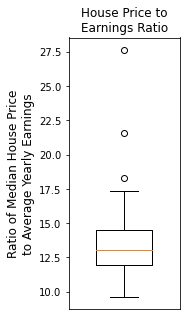


Summary Statistics for:

Tourist Expendature
(2009)

count      32.000000
mean      317.812500
std       602.590935
min        57.000000
25%       105.750000
50%       151.000000
75%       232.000000
max      3402.000000
Name: Tourism_Spend_2009(£m), dtype: float64

Box Plot:



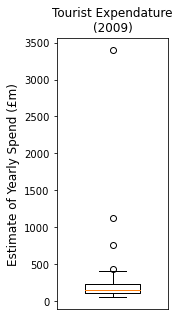


Summary Statistics for:

Rents per
Square Kilometer

count     32.000000
unique    32.000000
top       24.868169
freq       1.000000
Name: Rents/km^2, dtype: float64

Box Plot:



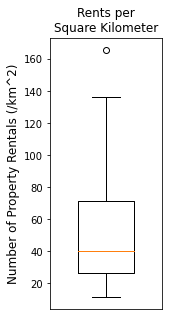


Summary Statistics for:

Open-Space Land
Percentage

count    32.000000
mean     33.487500
std      11.064204
min      13.700000
25%      26.325000
50%      32.150000
75%      38.000000
max      59.000000
Name: %Open_Space_2013, dtype: float64

Box Plot:



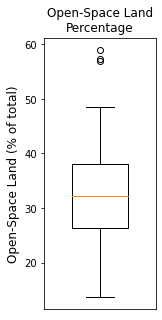

In [323]:
summary_stats(full_data['House_Earnings_Ratio'],
              'House Price to\nEarnings Ratio',
              'Ratio of Median House Price\nto Average Yearly Earnings')

summary_stats(full_data['Tourism_Spend_2009(£m)'],
              'Tourist Expendature\n(2009)',
              'Estimate of Yearly Spend (£m)')

summary_stats(full_data['Rents/km^2'],
              'Rents per\nSquare Kilometer',
              'Number of Property Rentals (/km^2)')

summary_stats(full_data['%Open_Space_2013'],
              'Open-Space Land\nPercentage',
              'Open-Space Land (% of total)')

In [ ]:
## Dependent Variables

In [324]:
# I can now read in the data needed to calculate my dependent variable(s)
# First, the income per borough for the those living in the borough
raw_redidents_earnings = pd.read_csv('Data/Earnings_Residents.csv', # Read in the csv
                                     encoding = 'utf-8')
raw_redidents_earnings.columns

Index(['Code', 'Area', '2002', 'Unnamed: 3', '2003', 'Unnamed: 5', '2004',
       'Unnamed: 7', '2005', 'Unnamed: 9', '2006', 'Unnamed: 11', '2007',
       'Unnamed: 13', '2008', 'Unnamed: 15', '2009', 'Unnamed: 17', '2010',
       'Unnamed: 19', '2011', 'Unnamed: 21', '2012', 'Unnamed: 23', '2013',
       'Unnamed: 25', '2014', 'Unnamed: 27', '2015', 'Unnamed: 29', '2016',
       'Unnamed: 31', '2017', 'Unnamed: 33', '2018', 'Unnamed: 35', '2019',
       'Unnamed: 37', '2020', 'Unnamed: 39'],
      dtype='object')